In [1]:
import netCDF4 as nc
from netCDF4 import num2date,date2index
import datetime
import csv
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

2024-01-08 10:33:31.798471: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 10:33:31.799778: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 10:33:31.818844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 10:33:31.818865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 10:33:31.819480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data = nc.Dataset('SLP.nc')

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description: Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.
    platform: Model
    NCO: 20121012
    title: monthly mean slp from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:10:47 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(144), lat(73)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 slp(time, lat, lon)
    groups: 

In [4]:
air = data.variables['slp']
print(air)

<class 'netCDF4._netCDF4.Variable'>
float32 slp(time, lat, lon)
    long_name: Sea Level Pressure
    units: millibars
    _FillValue: -9.96921e+36
    missing_value: -9.96921e+36
    precision: 1
    least_significant_digit: 1
    var_desc: Sea Level Pressure
    level_desc: Sea Level
    statistic: Mean
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products
    actual_range: [ 955.56085 1082.5582 ]
unlimited dimensions: time
current shape = (708, 73, 144)
filling off


In [5]:
latitude = data.variables['lat']
print(latitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 90. -90.]
unlimited dimensions: 
current shape = (73,)
filling off


In [6]:
latitude[:].shape

(73,)

In [7]:
longitude = data.variables['lon']
print(longitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.  357.5]
unlimited dimensions: 
current shape = (144,)
filling off


In [8]:
longitude[:]

masked_array(data=[  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,
                    20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
                    40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
                    60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
                    80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
                   100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
                   120. , 122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5,
                   140. , 142.5, 145. , 147.5, 150. , 152.5, 155. , 157.5,
                   160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
                   180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
                   200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5,
                   220. , 222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5,
                   240. , 242.5, 245. , 247.5, 250. , 252.5, 255. , 257.5,
                   260. ,

In [9]:
time = data.variables['time']
time_ = time[:]
time_units = time.units
time_calendar = time.calendar
time_dates = num2date(time_, units=time_units, calendar=time_calendar)
start_date = datetime.datetime(1958, 1, 1)
start_index = date2index(start_date, time, select='nearest')
air_subset = data['slp'][start_index:, :, :]

In [10]:
data_ = np.array(air_subset)
data_[data_ == -9.96921e+36] = 0

In [11]:
for date in time_dates:
    print(date)

1958-01-01 00:00:00
1958-02-01 00:00:00
1958-03-01 00:00:00
1958-04-01 00:00:00
1958-05-01 00:00:00
1958-06-01 00:00:00
1958-07-01 00:00:00
1958-08-01 00:00:00
1958-09-01 00:00:00
1958-10-01 00:00:00
1958-11-01 00:00:00
1958-12-01 00:00:00
1959-01-01 00:00:00
1959-02-01 00:00:00
1959-03-01 00:00:00
1959-04-01 00:00:00
1959-05-01 00:00:00
1959-06-01 00:00:00
1959-07-01 00:00:00
1959-08-01 00:00:00
1959-09-01 00:00:00
1959-10-01 00:00:00
1959-11-01 00:00:00
1959-12-01 00:00:00
1960-01-01 00:00:00
1960-02-01 00:00:00
1960-03-01 00:00:00
1960-04-01 00:00:00
1960-05-01 00:00:00
1960-06-01 00:00:00
1960-07-01 00:00:00
1960-08-01 00:00:00
1960-09-01 00:00:00
1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00


In [12]:
data_

array([[[1012.9961 , 1012.9961 , 1012.9961 , ..., 1012.9961 ,
         1012.9961 , 1012.9961 ],
        [1011.27997, 1011.2793 , 1011.2865 , ..., 1011.2904 ,
         1011.2788 , 1011.279  ],
        [1009.7007 , 1009.5694 , 1009.4475 , ..., 1010.13617,
         1009.9895 , 1009.8436 ],
        ...,
        [ 990.54675,  990.39264,  990.2639 , ...,  991.0222 ,
          990.871  ,  990.7112 ],
        [ 989.99097,  989.9565 ,  989.91583, ...,  990.1026 ,
          990.06866,  990.02954],
        [ 990.6226 ,  990.6226 ,  990.6226 , ...,  990.6226 ,
          990.6226 ,  990.6226 ]],

       [[1021.55176, 1021.55176, 1021.55176, ..., 1021.55176,
         1021.55176, 1021.55176],
        [1020.8135 , 1020.8164 , 1020.8158 , ..., 1020.7847 ,
         1020.79895, 1020.80505],
        [1020.3079 , 1020.2328 , 1020.15265, ..., 1020.44244,
         1020.414  , 1020.36755],
        ...,
        [1017.1109 , 1017.2514 , 1017.3432 , ..., 1016.1883 ,
         1016.6094 , 1016.9082 ],
        [101

In [13]:
np.max(data_)

1082.5582

In [14]:
np.min(data_)

955.56085

In [15]:
data_.shape

(708, 73, 144)

In [16]:
len(data_)

708

In [17]:
num_years = data_.shape[0] // 12
num_months = data_.shape[0] // num_years

In [18]:
num_years

59

In [19]:
num_months

12

In [20]:
data_reshaped = np.reshape(data_, (len(data_) // 12, 12, data_.shape[1],data_.shape[2]))

In [21]:
vwndlat_indices = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude <= start_value) & (latitude > end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude[range_indices])]
        max_index = range_indices[np.argmin(latitude[range_indices])]
        
        lat_indices.append(min_index)
        lat_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude[min_index]}, Max = {latitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 3, Min = 90.0, Max = 82.5
Range 80 to 70: Min index = 4, Max index = 7, Min = 80.0, Max = 72.5
Range 70 to 60: Min index = 8, Max index = 11, Min = 70.0, Max = 62.5
Range 60 to 50: Min index = 12, Max index = 15, Min = 60.0, Max = 52.5
Range 50 to 40: Min index = 16, Max index = 19, Min = 50.0, Max = 42.5
Range 40 to 30: Min index = 20, Max index = 23, Min = 40.0, Max = 32.5
Range 30 to 20: Min index = 24, Max index = 27, Min = 30.0, Max = 22.5
Range 20 to 10: Min index = 28, Max index = 31, Min = 20.0, Max = 12.5
Range 10 to 0: Min index = 32, Max index = 35, Min = 10.0, Max = 2.5
Range 0 to -10: Min index = 36, Max index = 39, Min = 0.0, Max = -7.5
Range -10 to -20: Min index = 40, Max index = 43, Min = -10.0, Max = -17.5
Range -20 to -30: Min index = 44, Max index = 47, Min = -20.0, Max = -27.5
Range -30 to -40: Min index = 48, Max index = 51, Min = -30.0, Max = -37.5
Range -40 to -50: Min index = 52, Max index = 55, Min = -40.0, Max = -47.

In [22]:
lat_indices

[0,
 3,
 4,
 7,
 8,
 11,
 12,
 15,
 16,
 19,
 20,
 23,
 24,
 27,
 28,
 31,
 32,
 35,
 36,
 39,
 40,
 43,
 44,
 47,
 48,
 51,
 52,
 55,
 56,
 59,
 60,
 63,
 64,
 67,
 68,
 71]

In [23]:
len(lat_indices)

36

In [24]:
lon_indices = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude >= start_value) & (longitude < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude[range_indices])]
        max_index = range_indices[np.argmax(longitude[range_indices])]
        
        lon_indices.append(min_index)
        lon_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude[min_index]}, Max = {longitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 7, Min = 0.0, Max = 17.5
Range 20 to 40: Min index = 8, Max index = 15, Min = 20.0, Max = 37.5
Range 40 to 60: Min index = 16, Max index = 23, Min = 40.0, Max = 57.5
Range 60 to 80: Min index = 24, Max index = 31, Min = 60.0, Max = 77.5
Range 80 to 100: Min index = 32, Max index = 39, Min = 80.0, Max = 97.5
Range 100 to 120: Min index = 40, Max index = 47, Min = 100.0, Max = 117.5
Range 120 to 140: Min index = 48, Max index = 55, Min = 120.0, Max = 137.5
Range 140 to 160: Min index = 56, Max index = 63, Min = 140.0, Max = 157.5
Range 160 to 180: Min index = 64, Max index = 71, Min = 160.0, Max = 177.5
Range 180 to 200: Min index = 72, Max index = 79, Min = 180.0, Max = 197.5
Range 200 to 220: Min index = 80, Max index = 87, Min = 200.0, Max = 217.5
Range 220 to 240: Min index = 88, Max index = 95, Min = 220.0, Max = 237.5
Range 240 to 260: Min index = 96, Max index = 103, Min = 240.0, Max = 257.5
Range 260 to 280: Min index = 104, Max index = 1

In [25]:
lon_indices

[0,
 7,
 8,
 15,
 16,
 23,
 24,
 31,
 32,
 39,
 40,
 47,
 48,
 55,
 56,
 63,
 64,
 71,
 72,
 79,
 80,
 87,
 88,
 95,
 96,
 103,
 104,
 111,
 112,
 119,
 120,
 127,
 128,
 135,
 136,
 143]

In [26]:
len(lon_indices)

36

In [27]:
for lat_idx in range(0, len(lat_indices), 2):
    lat_range_start = lat_indices[lat_idx]
    lat_range_end = lat_indices[lat_idx + 1]
    print(lat_range_start,lat_range_end)

0 3
4 7
8 11
12 15
16 19
20 23
24 27
28 31
32 35
36 39
40 43
44 47
48 51
52 55
56 59
60 63
64 67
68 71


In [28]:
for lon_idx in range(0, len(lon_indices),2):
    lon_range_start = lon_indices[lon_idx]
    lon_range_end = lon_indices[lon_idx + 1]
    print(lon_range_start,lon_range_end)

0 7
8 15
16 23
24 31
32 39
40 47
48 55
56 63
64 71
72 79
80 87
88 95
96 103
104 111
112 119
120 127
128 135
136 143


In [29]:
def coarse_gridding(data, lat_indices, lon_indices):
    coarsed_data = np.zeros((data.shape[0], data.shape[1], len(lat_indices) // 2, len(lon_indices) // 2))
    for lat_idx in range(0, len(lat_indices), 2):
        lat_range_start = lat_indices[lat_idx]
        lat_range_end = lat_indices[lat_idx + 1]
        for lon_idx in range(0, len(lon_indices), 2):
            lon_range_start = lon_indices[lon_idx]
            lon_range_end = lon_indices[lon_idx + 1]
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]
            averaged_value = np.mean(subset, axis=(2, 3))
            coarsed_data[:, :, lat_idx // 2, lon_idx // 2] = averaged_value
    return coarsed_data


In [30]:
 avg = coarse_gridding(data_reshaped,lat_indices,lon_indices)

In [31]:
avg.shape

(59, 12, 18, 18)

In [32]:
avg[1,1,:,1]

array([ 997.65979004,  993.06195068, 1007.27862549, 1020.58447266,
       1027.33666992, 1024.19238281, 1020.79614258, 1012.87451172,
       1007.64080811, 1010.81072998, 1009.41046143, 1008.9833374 ,
       1011.87927246, 1011.84533691,  997.52874756,  986.6237793 ,
        998.32653809, 1010.23895264])

In [33]:
final= np.reshape(avg, (len(data_) // 12, 12, 324))

In [34]:
final.shape

(59, 12, 324)

In [35]:
np.max(final)

1068.5726318359375

In [36]:
np.min(final)

958.583984375

In [37]:
ff= final.reshape(324,708)
ff.shape

(324, 708)

In [38]:
def calculate_monthly_anomaliess(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies

def min_max_normalize(data):
    normalized_data = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]

            # Calculate min and max values for each month
            min_value = np.min(month)
            max_value = np.max(month)

            # Normalize each month value
            normalized_month = (month - min_value) / (max_value - min_value)

            # Store normalized month data
            normalized_data[:, j, i] = normalized_month


    return normalized_data




In [39]:
anomalies = calculate_monthly_anomaliess(final)
anomalies

array([[[-1.36071570e+00, -1.43362272e+00, -1.28568281e+00, ...,
         -1.96499479e+00, -4.14394780e+00, -7.02194886e+00],
        [ 7.84649451e+00,  7.63605357e+00,  7.21721378e+00, ...,
          4.62494103e+00,  2.72797355e+00,  1.16117626e+00],
        [ 9.91077074e+00,  9.80127263e+00,  9.42240776e+00, ...,
         -7.07677809e-01, -1.09490243e+00, -2.25057621e+00],
        ...,
        [-3.06941559e+00, -3.00015414e+00, -2.92287639e+00, ...,
          2.17967922e-03, -5.10594255e-01, -1.94822667e+00],
        [-2.25862147e-01, -1.50836492e-01,  2.29295634e-01, ...,
          2.50864113e+00,  1.39477125e+00, -2.23173497e-01],
        [ 9.87339136e+00,  1.01615870e+01,  1.03655768e+01, ...,
         -3.12487483e+00, -4.86838234e+00, -6.59111928e+00]],

       [[ 1.14600240e+01,  1.06411454e+01,  9.86177813e+00, ...,
         -1.78939664e+00, -1.90853520e+00, -2.14548402e+00],
        [-1.48138448e+01, -1.52116027e+01, -1.54559430e+01, ...,
         -8.86472540e-01, -2.55596200e

In [40]:
np.max((anomalies))

26.268446065611784

In [41]:
np.min((anomalies))

-27.711992684057122

In [42]:
normalized_data = min_max_normalize(anomalies)

In [43]:
normalized_data

array([[[0.42780309, 0.41670077, 0.4109543 , ..., 0.45165511,
         0.30510256, 0.08453275],
        [0.71798622, 0.69199997, 0.66935808, ..., 0.75271577,
         0.60420305, 0.54066492],
        [0.76517914, 0.77444951, 0.77445744, ..., 0.44882843,
         0.41555007, 0.37433847],
        ...,
        [0.36847335, 0.39174636, 0.4159843 , ..., 0.42876342,
         0.35203393, 0.30147993],
        [0.58019284, 0.56878619, 0.57866556, ..., 0.60782399,
         0.55089168, 0.4755579 ],
        [0.79066492, 0.78899393, 0.78407965, ..., 0.27708886,
         0.21258464, 0.16174425]],

       [[0.85014135, 0.7967549 , 0.74992855, ..., 0.46083524,
         0.42424893, 0.37507   ],
        [0.01369255, 0.        , 0.        , ..., 0.4714061 ,
         0.29437112, 0.22985542],
        [0.03212996, 0.02129775, 0.02320738, ..., 0.55925702,
         0.4546381 , 0.4087468 ],
        ...,
        [0.51361162, 0.54107784, 0.56864701, ..., 0.36838535,
         0.2710822 , 0.30632488],
        [0.6

In [44]:
normalized_data.shape

(59, 12, 324)

In [45]:
np.max(np.abs(anomalies))

27.711992684057122

In [46]:
num_positive_values = np.sum(anomalies > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 115911
Number of negative values: 113481
Number of zero values: 0


In [47]:
anomalies.shape

(59, 12, 324)

In [48]:
tf.random.set_seed(12345)

In [49]:
input_dim = 324
hidden_dim = 65
input_layer = Input(shape = (input_dim,))
hidden_layer = Dense(hidden_dim,activation='tanh')(input_layer)
output_layer = Dense(input_dim,activation='linear')(hidden_layer)

2024-01-08 10:33:33.502194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 10:33:33.502456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [50]:
input_data = normalized_data.reshape(-1, input_dim)
input_data.shape

(708, 324)

In [51]:
input_data

array([[0.42780309, 0.41670077, 0.4109543 , ..., 0.45165511, 0.30510256,
        0.08453275],
       [0.71798622, 0.69199997, 0.66935808, ..., 0.75271577, 0.60420305,
        0.54066492],
       [0.76517914, 0.77444951, 0.77445744, ..., 0.44882843, 0.41555007,
        0.37433847],
       ...,
       [0.64227445, 0.66749247, 0.69263946, ..., 0.3859323 , 0.28612803,
        0.22191595],
       [0.52087099, 0.53784069, 0.55839209, ..., 0.66361371, 0.79231947,
        0.82612814],
       [0.25688451, 0.28881091, 0.32022321, ..., 0.48158901, 0.57336781,
        0.70714447]])

In [52]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [53]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 324)]             0         
                                                                 
 dense (Dense)               (None, 65)                21125     
                                                                 
 dense_1 (Dense)             (None, 324)               21384     
                                                                 
Total params: 42509 (166.05 KB)
Trainable params: 42509 (166.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
autoencoder.fit(input_data, input_data, epochs=10
                , batch_size=8)

Epoch 1/10
89/89 [==============================] - 0s 503us/step - loss: 0.0827
Epoch 2/10
89/89 [==============================] - 0s 415us/step - loss: 0.0427
Epoch 3/10
89/89 [==============================] - 0s 868us/step - loss: 0.0344
Epoch 4/10
89/89 [==============================] - 0s 533us/step - loss: 0.0302
Epoch 5/10
89/89 [==============================] - 0s 393us/step - loss: 0.0270
Epoch 6/10
89/89 [==============================] - 0s 664us/step - loss: 0.0243
Epoch 7/10
89/89 [==============================] - 0s 478us/step - loss: 0.0220
Epoch 8/10
89/89 [==============================] - 0s 505us/step - loss: 0.0201
Epoch 9/10
89/89 [==============================] - 0s 505us/step - loss: 0.0185
Epoch 10/10
89/89 [==============================] - 0s 560us/step - loss: 0.0172


In [56]:
encoded_data = autoencoder.predict(input_data)

23/23 [==============================] - 0s 322us/step


In [57]:
encoded_data.shape

(708, 324)

In [58]:
decoded_data = autoencoder.predict(encoded_data)

23/23 [==============================] - 0s 369us/step


In [59]:
decoded_data.shape

(708, 324)

In [60]:
weights = autoencoder.get_weights()[0]# Get the weights of the first layer (between input and hidden)
weights

array([[-0.08279715,  0.04408914,  0.01384057, ..., -0.08370641,
         0.07129371, -0.0267418 ],
       [-0.06500965, -0.08688554,  0.11234286, ..., -0.01243901,
        -0.08623107, -0.04747421],
       [ 0.01807197,  0.04083145,  0.0135942 , ...,  0.06721298,
        -0.07947224,  0.06309234],
       ...,
       [-0.04171707,  0.10647195, -0.12011951, ..., -0.12898795,
         0.05749301,  0.02843753],
       [-0.12473067, -0.0827243 ,  0.05808433, ..., -0.01186434,
        -0.03593127,  0.06431491],
       [ 0.07215831,  0.09203706, -0.09099384, ...,  0.024574  ,
         0.06594948,  0.11076311]], dtype=float32)

In [63]:
np.save('weights.npy', weights)

In [64]:
weights = np.load('weights.npy')

In [65]:
weights

array([[-0.08279715,  0.04408914,  0.01384057, ..., -0.08370641,
         0.07129371, -0.0267418 ],
       [-0.06500965, -0.08688554,  0.11234286, ..., -0.01243901,
        -0.08623107, -0.04747421],
       [ 0.01807197,  0.04083145,  0.0135942 , ...,  0.06721298,
        -0.07947224,  0.06309234],
       ...,
       [-0.04171707,  0.10647195, -0.12011951, ..., -0.12898795,
         0.05749301,  0.02843753],
       [-0.12473067, -0.0827243 ,  0.05808433, ..., -0.01186434,
        -0.03593127,  0.06431491],
       [ 0.07215831,  0.09203706, -0.09099384, ...,  0.024574  ,
         0.06594948,  0.11076311]], dtype=float32)

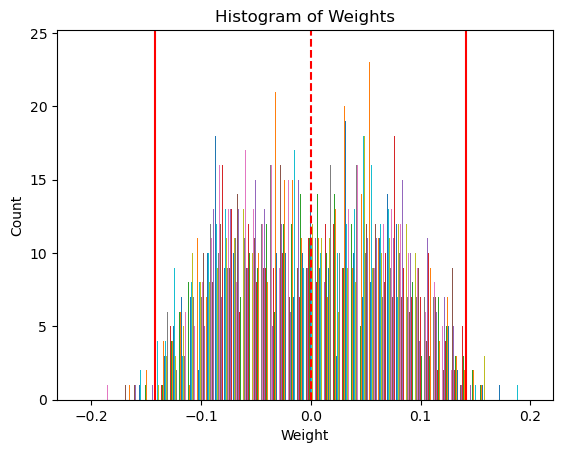

In [66]:
import matplotlib.pyplot as plt
# Calculate the mean and standard deviation of the weights.
mean = np.mean(weights)
sigma = np.std(weights)

# Plot a histogram of the weights.
plt.hist(weights, bins=50)
plt.axvline(mean, color='red', linestyle='dashed')
plt.axvline(mean + 2*sigma, color='red')
plt.axvline(mean - 2*sigma, color='red')
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [67]:
weights.shape

(324, 65)

In [117]:
def Tweights(weight):
    num = []

    for i in range(weight.shape[1]):
        weight_mean = np.mean(weight[:, i])
        weight_std = np.std(weight[:, i])
        threshold_upper = weight_mean + 1.4 * weight_std
        threshold_lower = weight_mean - 1.4 * weight_std
        nodes_with_weight_above_upper_threshold = np.sum(weight[:, i] > threshold_upper)
        nodes_with_weight_below_lower_threshold = np.sum(weight[:, i] < threshold_lower)
        ten_percent_nodes = int(0.1 * weight.shape[0])

        if nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold > ten_percent_nodes:
            num.append(nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold)
            print(i, nodes_with_weight_above_upper_threshold, threshold_upper, nodes_with_weight_below_lower_threshold, threshold_lower)

    return num




In [118]:
we = Tweights(weights)
we

0 15 0.1101196613162756 22 -0.10132958181202412
1 11 0.12022899556905031 27 -0.09918982814997435
2 21 0.10541405620460864 22 -0.10520765838737134
3 26 0.10439442843198776 19 -0.1091032400727272
4 20 0.10785160480008926 18 -0.1080981391860405
5 18 0.10156058822758496 22 -0.09768746490590274
6 19 0.10107645043171942 23 -0.1086354365106672
7 24 0.11009926054248353 23 -0.1098999485038803
8 19 0.10731443063741608 22 -0.10727570159906463
9 20 0.10568811895791441 19 -0.10304874030407518
10 22 0.10666219622362405 21 -0.10610917478334159
11 21 0.10737684601917863 25 -0.10489579057320952
12 19 0.1001650276593864 26 -0.10894510569050908
13 20 0.11193696781992912 19 -0.09204031154513359
14 19 0.10153081221506 24 -0.11111369030550122
15 31 0.1004874084610492 18 -0.10481512802653015
16 22 0.10644399165175855 20 -0.10097930044867098
17 23 0.10557004707516171 24 -0.10597001118003391
18 24 0.10871026857057586 25 -0.1101049687131308
19 19 0.104230135679245 23 -0.09832720458507538
20 20 0.109745784167898

[37,
 38,
 43,
 45,
 38,
 40,
 42,
 47,
 41,
 39,
 43,
 46,
 45,
 39,
 43,
 49,
 42,
 47,
 49,
 42,
 41,
 39,
 52,
 45,
 43,
 39,
 43,
 44,
 33,
 36,
 37,
 44,
 40,
 36,
 42,
 38,
 42,
 45,
 40,
 44,
 38,
 35,
 49,
 44,
 47,
 40,
 45,
 38,
 45,
 39,
 41,
 42,
 44,
 39,
 48,
 49,
 41,
 46,
 45,
 41,
 40,
 42,
 39,
 42]

In [119]:
len(we)

64

In [71]:
pred = np.zeros((65,708))
for i in range(weights.shape[1]):
    weight_mean = np.mean(weights[:,i])
    weight_std = np.std(weights[:,i])
    threshold_upper = weight_mean + 1.4 * weight_std
    threshold_lower = weight_mean - 1.4 * weight_std
    nodes_with_weight_above_upper_threshold = np.sum(weights[:, i] > threshold_upper)
    nodes_with_weight_below_lower_threshold = np.sum(weights[:, i] < threshold_lower)
    ten_percent_nodes = int(0.1 * weights.shape[0])
    if (nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold) > ten_percent_nodes:
        for h in range(input_data.shape[0]): 
            pred_i = 0
            for j in range(weights.shape[0]):
                weight_value = weights[j,i]
                if weight_value > threshold_upper or weight_value < threshold_lower:
                    pp = np.sum(weight_value*input_data[h,j])
                    pred_i += pp
                    pred[i,h] = pred_i
                

print(pred)

[[-0.14336342 -0.20781656 -0.33827206 ... -0.66938673 -0.8752877
  -0.81440559]
 [-0.48149749 -0.50663847 -0.4701113  ... -0.41083267 -0.64990668
  -0.37964763]
 [-0.40547097 -0.40904567 -0.10143444 ... -0.3983465  -0.1676487
  -0.50587092]
 ...
 [ 0.11359228 -0.04376325  0.28973214 ... -0.06540809  0.22098848
  -0.11199137]
 [ 0.27415117 -0.34440276  0.43864881 ...  0.36825688  0.15663626
  -0.03343249]
 [-0.13279173 -0.25343707 -0.28660547 ... -0.58350385  0.14481025
   0.20260705]]


In [72]:
weight_value

0.11076311

In [73]:
number_of_zeros = np.count_nonzero( pred == 0)

In [74]:
number_of_zeros

0

In [75]:
pred.shape

(65, 708)

In [76]:
predd = pred[12,:].reshape(59,12)
predd

array([[-8.38499950e-02, -2.52359247e-01, -3.07294001e-01,
        -2.29258352e-02,  2.73339255e-02, -7.97069648e-02,
        -1.79793993e-01, -1.87077967e-01, -4.27208825e-01,
        -5.72448633e-01, -1.19330088e-01,  3.96520522e-03],
       [-4.48653376e-02, -3.63125272e-01, -2.96034531e-01,
        -2.03287104e-01, -2.83214174e-01, -4.69492516e-01,
         1.19360964e-01, -3.64676691e-01, -1.63035299e-01,
        -2.23165224e-01,  3.16202009e-02, -2.30924859e-01],
       [ 1.26870240e-01, -4.39820008e-01, -7.98914964e-02,
         4.73095937e-02, -2.68885098e-01, -3.41046657e-01,
         1.03095735e-01,  7.88898764e-02, -3.65968142e-01,
        -2.82011443e-01,  1.94890359e-01,  1.88369695e-01],
       [ 1.23775472e-01, -4.87146856e-01, -2.57557003e-01,
        -2.82688322e-01, -2.98533015e-01,  3.20225517e-01,
        -3.58387527e-01,  6.15784264e-02, -1.21590316e-01,
        -1.05635067e-01, -5.36533452e-01, -3.58643254e-01],
       [-9.13385611e-02, -3.90164356e-01, -3.1275981

In [77]:
df = pd.read_csv("enso_index.csv")
df

,year,january,february,march,april,may,june,july,august,september,october,november,december,avg
0,1958,1.54,1.40,0.99,0.31,0.32,0.30,0.04,0.24,-0.31,-0.03,0.05,0.30,0.0675
1,1959,0.43,0.50,0.26,0.27,-0.01,-0.33,-0.28,-0.41,-0.53,0.11,-0.17,-0.05,-0.3875
2,1960,0.02,-0.24,-0.08,0.01,0.05,-0.20,-0.25,0.00,0.03,-0.07,-0.38,0.02,-0.1050
3,1961,-0.15,0.04,-0.10,0.13,-0.01,0.10,-0.32,-0.25,-0.52,-0.71,-0.19,-0.29,-0.2475
4,1962,-0.25,-0.16,-0.41,-0.32,-0.42,-0.22,-0.30,-0.13,-0.56,-0.33,-0.43,-0.49,-0.3025
5,1963,-0.32,-0.26,-0.06,-0.06,0.00,0.12,0.72,0.90,0.65,0.84,0.75,1.05,0.5975
6,1964,0.76,0.55,-0.16,-0.53,-0.74,-0.88,-0.65,-0.76,-0.93,-1.00,-1.10,-1.07,-0.8050
7,1965,-0.57,-0.36,-0.34,-0.09,0.19,0.45,0.81,1.25,1.26,1.61,1.54,1.45,0.9425
8,1966,1.13,0.83,0.83,0.54,-0.06,0.14,0.23,-0.10,-0.05,-0.05,-0.37,-0.26,0.0550
9,1967,-0.55,-0.56,-0.47,-0.53,-0.24,-0.12,-0.10,-0.31,-0.59,-0.38,-0.34,-0.35,-0.2800


In [78]:
pred_pres = pred[12,:].reshape(59,12)
years = pd.date_range(start='1958', end='2016', freq='YS').year
months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
df_pres = df_pres.reset_index()
df_pres['enso_avg'] = df['avg'].copy()
df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
df_pres.index = df_pres.index + 1  # shifting index
df_pres = df_pres.sort_index() 
df_pres= df_pres.drop('index',axis=1)
df_6 = df_pres.iloc[1:, :5]
df_6 = df_6.reset_index()
df_12 = df_pres.iloc[0:-1, 5:12]
df_12 = df_12.reset_index()
df_13 = df_pres.iloc[1:, [12]]
df_13 = df_13.reset_index()
df_last = pd.concat([df_6, df_12, df_13], axis=1)
df_last = df_last.drop('index',axis=1)
correlation = df_last.corr(method='pearson')

In [79]:
df_12

,index,June,July,August,September,October,November,December
0,0,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965
1,1,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965
2,2,-0.469493,0.119361,-0.364677,-0.163035,-0.223165,0.031620,-0.230925
3,3,-0.341047,0.103096,0.078890,-0.365968,-0.282011,0.194890,0.188370
4,4,0.320226,-0.358388,0.061578,-0.121590,-0.105635,-0.536533,-0.358643
5,5,-0.306843,-0.914322,-0.160243,-0.282158,-0.298154,-0.336952,0.009897
6,6,-0.156246,-0.302137,-0.293405,-0.143895,0.098570,-0.487934,-0.326148
7,7,-0.183193,-0.626665,-0.310553,-0.166060,-0.277138,-0.315154,-0.373268
8,8,0.187573,-0.304144,-0.166747,-0.000302,-0.393194,-0.602052,-0.464908
9,9,-0.320285,-0.072288,-0.478735,-0.092635,-0.130150,-0.310291,-0.327157


In [80]:
df_pres

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965,0.0675
1,-0.083850,-0.252359,-0.307294,-0.022926,0.027334,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965,0.0675
2,-0.044865,-0.363125,-0.296035,-0.203287,-0.283214,-0.469493,0.119361,-0.364677,-0.163035,-0.223165,0.031620,-0.230925,-0.3875
3,0.126870,-0.439820,-0.079891,0.047310,-0.268885,-0.341047,0.103096,0.078890,-0.365968,-0.282011,0.194890,0.188370,-0.1050
4,0.123775,-0.487147,-0.257557,-0.282688,-0.298533,0.320226,-0.358388,0.061578,-0.121590,-0.105635,-0.536533,-0.358643,-0.2475
5,-0.091339,-0.390164,-0.312760,-0.452914,-0.482079,-0.306843,-0.914322,-0.160243,-0.282158,-0.298154,-0.336952,0.009897,-0.3025
6,-0.026529,-0.089188,-0.018722,-0.128221,0.290990,-0.156246,-0.302137,-0.293405,-0.143895,0.098570,-0.487934,-0.326148,0.5975
7,-0.378880,-0.191562,-0.178238,-0.454608,-0.182332,-0.183193,-0.626665,-0.310553,-0.166060,-0.277138,-0.315154,-0.373268,-0.8050
8,-0.086351,-0.619972,-0.563890,-0.148642,-0.368372,0.187573,-0.304144,-0.166747,-0.000302,-0.393194,-0.602052,-0.464908,0.9425
9,-0.590621,-0.255672,-0.460613,-0.301622,-0.563188,-0.320285,-0.072288,-0.478735,-0.092635,-0.130150,-0.310291,-0.327157,0.0550


In [81]:
df_last

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,-0.083850,-0.252359,-0.307294,-0.022926,0.027334,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965,0.0675
1,-0.044865,-0.363125,-0.296035,-0.203287,-0.283214,-0.079707,-0.179794,-0.187078,-0.427209,-0.572449,-0.119330,0.003965,-0.3875
2,0.126870,-0.439820,-0.079891,0.047310,-0.268885,-0.469493,0.119361,-0.364677,-0.163035,-0.223165,0.031620,-0.230925,-0.1050
3,0.123775,-0.487147,-0.257557,-0.282688,-0.298533,-0.341047,0.103096,0.078890,-0.365968,-0.282011,0.194890,0.188370,-0.2475
4,-0.091339,-0.390164,-0.312760,-0.452914,-0.482079,0.320226,-0.358388,0.061578,-0.121590,-0.105635,-0.536533,-0.358643,-0.3025
5,-0.026529,-0.089188,-0.018722,-0.128221,0.290990,-0.306843,-0.914322,-0.160243,-0.282158,-0.298154,-0.336952,0.009897,0.5975
6,-0.378880,-0.191562,-0.178238,-0.454608,-0.182332,-0.156246,-0.302137,-0.293405,-0.143895,0.098570,-0.487934,-0.326148,-0.8050
7,-0.086351,-0.619972,-0.563890,-0.148642,-0.368372,-0.183193,-0.626665,-0.310553,-0.166060,-0.277138,-0.315154,-0.373268,0.9425
8,-0.590621,-0.255672,-0.460613,-0.301622,-0.563188,0.187573,-0.304144,-0.166747,-0.000302,-0.393194,-0.602052,-0.464908,0.0550
9,-0.270068,-0.260532,-0.241778,-0.591287,-0.070268,-0.320285,-0.072288,-0.478735,-0.092635,-0.130150,-0.310291,-0.327157,-0.2800


In [82]:
correlation

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
January,1.000000,0.200857,0.046017,-0.001885,-0.040759,-0.175309,0.023218,0.080347,-0.037863,0.004638,0.028773,0.325788,-0.001878
February,0.200857,1.000000,-0.087445,-0.300178,0.070080,0.011637,-0.041324,0.037087,0.113006,-0.165134,-0.379615,-0.034804,-0.111354
March,0.046017,-0.087445,1.000000,0.012643,0.489431,-0.099090,0.087892,-0.036997,-0.085505,0.098720,0.252844,-0.009735,0.150614
April,-0.001885,-0.300178,0.012643,1.000000,0.064258,0.348061,-0.124622,0.095509,-0.197040,0.017219,0.257890,0.017523,0.086585
May,-0.040759,0.070080,0.489431,0.064258,1.000000,-0.009419,0.107068,-0.175815,-0.052517,0.000891,0.143118,0.031377,0.043890
June,-0.175309,0.011637,-0.099090,0.348061,-0.009419,1.000000,-0.003991,0.061590,-0.142554,-0.061874,-0.031153,-0.168549,-0.354934
July,0.023218,-0.041324,0.087892,-0.124622,0.107068,-0.003991,1.000000,0.164820,-0.049686,0.022100,0.199395,0.089576,-0.152227
August,0.080347,0.037087,-0.036997,0.095509,-0.175815,0.061590,0.164820,1.000000,0.000616,0.087688,-0.088549,0.214194,0.136346
September,-0.037863,0.113006,-0.085505,-0.197040,-0.052517,-0.142554,-0.049686,0.000616,1.000000,0.100874,-0.316811,-0.160246,-0.038026
October,0.004638,-0.165134,0.098720,0.017219,0.000891,-0.061874,0.022100,0.087688,0.100874,1.000000,0.158505,0.080417,0.118339


In [83]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='pearson')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [84]:
top_predp,resultp = potential_predictors_new(pred)

0 -0.2078779883063855 July 0.2078779883063855
1 0.38848723808079677 November 0.38848723808079677
2 0.24845562450824865 October 0.24845562450824865
3 -0.33398471122800516 March 0.33398471122800516
4 -0.2799602963783686 November_2 0.2799602963783686
5 -0.2470396497925393 May 0.2470396497925393
6 -0.3472524455818595 November_3 0.3472524455818595
7 -0.5078274921198955 May_2 0.5078274921198955
8 -0.2746498487632991 September 0.2746498487632991
9 -0.3488626225911929 April 0.3488626225911929
10 -0.3240491000474944 September_2 0.3240491000474944
11 0.17246842147173194 April_2 0.17246842147173194
12 -0.3549344705317289 June 0.3549344705317289
13 0.23106589737634445 September_3 0.23106589737634445
14 -0.3233834969382148 May_3 0.3233834969382148
15 -0.36412967877871705 April_3 0.36412967877871705
16 0.3374794316368223 November_4 0.3374794316368223
17 -0.31558105756695215 April_4 0.31558105756695215
18 0.3861576686358032 April_5 0.3861576686358032
19 -0.3722783436718177 July_2 0.3722783436718177
2

In [85]:
resultp = resultp.sort_values(by='Absolute_Correlation', ascending=False)
resultp

,Iteration,Correlation,Column_Name,Absolute_Correlation
7,7,-0.507827,May_2,0.507827
33,33,-0.449080,November_7,0.449080
50,50,0.448521,May_9,0.448521
56,56,-0.428964,July_7,0.428964
63,63,-0.406202,October_6,0.406202
...,...,...,...,...
28,28,-0.186864,November_6,0.186864
45,45,0.186013,November_9,0.186013
46,46,-0.174025,August_2,0.174025
11,11,0.172468,April_2,0.172468


In [86]:
top_predp['March_2']

0     0.510411
1     0.027248
2    -0.026327
3     0.293822
4     0.351204
5    -0.160607
6     0.268486
7     0.053775
8     0.112628
9     0.100827
10    0.336132
11    0.449146
12    0.569217
13    0.085439
14   -0.011658
15   -0.212626
16    0.037976
17    0.201208
18   -0.037495
19   -0.229880
20    0.261083
21   -0.160804
22    0.171377
23    0.298921
24   -0.332582
25    0.366550
26    0.239245
27    0.283695
28   -0.082528
29    0.329421
30    0.130184
31    0.018632
32   -0.238869
33    0.336941
34    0.281431
35   -0.078926
36    0.013749
37    0.076284
38    0.307047
39   -0.305949
40    0.030771
41    0.452631
42    0.141847
43   -0.028913
44    0.120597
45    0.330232
46   -0.329390
47    0.370904
48   -0.114094
49   -0.078371
50    0.066954
51   -0.274625
52    0.314848
53    0.393692
54   -0.266290
55   -0.176912
56   -0.153432
57   -0.377274
58   -0.367969
Name: March_2, dtype: float64

In [87]:
unique_values_listp = resultp['Column_Name'].unique().tolist()

In [88]:
top_predp = top_predp[unique_values_listp]

In [89]:
top_predp

,May_2,November_7,May_9,July_7,October_6,March_4,May_5,April_8,November,March_2,...,January,July_5,March_3,July,December_2,November_6,November_9,August_2,April_2,February
0,-0.456360,0.073594,-0.716983,-0.247818,0.266111,-0.062858,-0.409467,-0.014352,0.096351,0.510411,...,0.398386,-0.052737,-0.478982,-0.322279,-0.468110,0.260434,-0.322899,-0.481466,-0.044647,0.253996
1,0.332166,0.073594,-0.600944,-0.247818,0.266111,-0.027647,-0.168900,-0.082749,0.096351,0.027248,...,0.342851,-0.052737,-0.639056,-0.322279,-0.468110,0.260434,-0.322899,-0.481466,-0.382810,0.285447
2,0.030945,0.207152,-1.118022,-0.379068,0.164306,0.008277,-0.550947,-0.261384,-0.218011,-0.026327,...,0.130251,0.162897,-0.389747,-0.433513,-0.370937,0.665407,0.124181,-0.173318,-0.315192,-0.030624
3,0.290044,0.329676,-0.522947,-0.450744,0.256191,-0.231707,0.108472,-0.245163,-0.267691,0.293822,...,0.475150,0.352314,-0.333498,-0.415735,-0.108260,0.712710,-0.116738,-0.576161,-0.686302,0.616793
4,0.402890,0.089461,-0.877231,-0.380579,0.303512,0.035182,-0.527781,0.390409,-0.853638,0.351204,...,-0.519542,0.073374,-0.422012,-0.252876,-0.542477,0.719603,-0.312628,-0.159279,-0.896381,0.091247
5,0.230979,-0.061063,-0.664730,-0.381681,0.194712,-0.287736,-0.297511,-0.029843,-0.460603,-0.160607,...,0.059722,-0.156800,-0.661736,0.032659,-0.282533,0.383175,-0.081865,-0.300303,-0.469524,-0.071780
6,0.322157,0.608538,-0.505595,-0.317771,0.235005,-0.288759,-0.367218,-0.016462,-0.569302,0.268486,...,0.371504,0.232124,-0.729963,-0.030021,-0.477253,0.724654,-0.273163,0.090729,-0.114103,0.477344
7,0.354008,0.352647,-0.741585,-0.593889,0.091647,-0.703806,-0.114192,0.390147,-0.455045,0.053775,...,0.692052,0.163635,-0.592157,-0.821699,0.073621,0.570346,-0.066174,-0.346778,-0.048165,0.651600
8,0.327928,0.240825,-0.521199,-0.244532,0.188610,-0.533328,0.240122,-0.364563,-0.491130,0.112628,...,0.256398,0.377283,-0.394188,-0.468583,-0.825234,0.743389,-0.111520,-0.154990,-0.654722,0.304319
9,0.192342,0.229326,-0.272887,-0.172238,0.372488,-0.393036,-0.279585,0.421437,-0.381082,0.100827,...,0.154545,-0.040131,-0.730159,-0.173472,-0.337817,0.103996,-0.075404,-0.436369,-0.185617,0.492732


In [90]:
top_predp.to_csv('pearson_corr.csv', index=False)

In [91]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='kendall')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [92]:
top_predk,resultk = potential_predictors_new(pred)

0 0.11706179518991486 December 0.11706179518991486
1 0.2762658366481991 November 0.2762658366481991
2 0.17091022097727573 November_2 0.17091022097727573
3 -0.21708616386811036 March 0.21708616386811036
4 -0.19251037173209784 May 0.19251037173209784
5 -0.1772967861240901 May_2 0.1772967861240901
6 0.16739836712157827 December_2 0.16739836712157827
7 -0.3399651245481728 May_3 0.3399651245481728
8 0.19602119918009964 April 0.19602119918009964
9 -0.26038636906013235 April_2 0.26038636906013235
10 -0.24114729809122462 September 0.24114729809122462
11 0.13579168242030126 July 0.13579168242030126
12 -0.21305246724564506 June 0.21305246724564506
13 0.1826164004962672 September_2 0.1826164004962672
14 0.18846949025576296 November_3 0.18846949025576296
15 -0.25804581742813115 April_3 0.25804581742813115
16 0.20485814158235102 November_4 0.20485814158235102
17 -0.20655368152410497 May_4 0.20655368152410497
18 0.30368657425215434 April_4 0.30368657425215434
19 -0.25168285965831694 July_2 0.2516828

In [93]:
resultk = resultk.sort_values(by='Absolute_Correlation', ascending=False)
resultk

,Iteration,Correlation,Column_Name,Absolute_Correlation
7,7,-0.339965,May_3,0.339965
18,18,0.303687,April_4,0.303687
32,32,-0.290313,October_2,0.290313
27,27,-0.287303,March_3,0.287303
33,33,-0.285631,November_5,0.285631
...,...,...,...,...
31,31,0.126975,January_2,0.126975
34,34,-0.124086,July_4,0.124086
29,29,-0.122915,October,0.122915
55,55,0.119403,November_8,0.119403


In [94]:
top_predk['March_4']

0     0.117879
1    -0.131802
2    -0.039575
3    -0.028882
4     0.202039
5     0.075873
6     0.223122
7     0.071764
8    -0.048613
9     0.093371
10    0.123784
11    0.451816
12    0.446063
13    0.086047
14    0.001581
15    0.071330
16    0.117231
17    0.021164
18   -0.233124
19   -0.058942
20    0.111865
21    0.175408
22   -0.045467
23    0.258208
24   -0.233394
25    0.116374
26    0.249806
27   -0.237844
28   -0.165897
29    0.057212
30    0.297425
31    0.136073
32    0.156526
33   -0.242790
34   -0.115446
35   -0.040737
36    0.072278
37    0.202600
38    0.051494
39    0.054669
40    0.355138
41    0.282323
42    0.265330
43    0.080369
44    0.274146
45   -0.024662
46   -0.039739
47    0.295262
48    0.037315
49    0.141324
50    0.476316
51    0.154362
52    0.054196
53    0.158144
54   -0.021650
55    0.386997
56   -0.072609
57   -0.093015
58   -0.214521
Name: March_4, dtype: float64

In [95]:
unique_values_listk = resultk['Column_Name'].unique().tolist()

In [96]:
top_predk = top_predk[unique_values_listk]

In [97]:
top_predk

,May_3,April_4,October_2,March_3,November_5,May_14,November,October_3,March_2,April_7,...,December_3,March_5,May_6,July,January,January_2,July_4,October,November_8,December
0,-0.456360,0.290480,-0.210838,-0.062858,0.073594,-0.716983,0.096351,-0.229150,0.510411,-0.174771,...,0.553414,-0.352286,-0.137301,-0.308901,-0.251126,0.398386,-0.052737,-0.077311,0.143686,0.114397
1,0.332166,0.164445,-0.210838,-0.027647,0.073594,-0.600944,0.096351,-0.229150,0.027248,-0.353441,...,0.553414,-0.003823,-0.383339,-0.308901,-0.034468,0.342851,-0.052737,-0.077311,0.143686,0.114397
2,0.030945,-0.268834,0.303240,0.008277,0.207152,-1.118022,-0.218011,-0.623752,-0.026327,-0.349360,...,0.725157,0.257698,-0.580078,0.021839,-0.140631,0.130251,0.162897,-0.398379,-0.289129,-0.073242
3,0.290044,-0.496887,-0.589375,-0.231707,0.329676,-0.522947,-0.267691,-0.109229,0.293822,-0.553450,...,0.760434,0.041613,-0.524638,-0.519258,-0.059489,0.475150,0.352314,-0.164990,-0.344064,0.111097
4,0.402890,-0.201643,0.282277,0.035182,0.089461,-0.877231,-0.853638,-0.556845,0.351204,-0.270608,...,0.721998,0.119713,-0.881780,-0.567651,0.126133,-0.519542,0.073374,-0.070817,-0.282555,0.044643
5,0.230979,0.082711,-0.428839,-0.287736,-0.061063,-0.664730,-0.460603,-0.030326,-0.160607,-0.336038,...,0.603064,-0.048291,-0.536441,-0.963303,-0.262375,0.059722,-0.156800,-0.341797,0.307795,-0.021434
6,0.322157,-0.551298,0.262491,-0.288759,0.608538,-0.505595,-0.569302,-0.722612,0.268486,-0.484265,...,1.075913,-0.337167,-0.466259,-0.480739,0.505269,0.371504,0.232124,0.025752,-0.710363,-0.372696
7,0.354008,0.307158,-0.580313,-0.703806,0.352647,-0.741585,-0.455045,0.140955,0.053775,-0.101307,...,0.571754,-0.074792,-0.426007,0.190542,0.241359,0.692052,0.163635,-0.160323,-1.063657,-0.395247
8,0.327928,0.391321,-0.218753,-0.533328,0.240825,-0.521199,-0.491130,-1.277981,0.112628,-0.284267,...,0.682463,-0.268155,-0.696014,-0.420299,0.108239,0.256398,0.377283,-0.569838,-1.026638,-0.216658
9,0.192342,0.117575,0.287858,-0.393036,0.229326,-0.272887,-0.381082,-0.421144,0.100827,-0.024779,...,0.436520,-0.051846,-0.435619,-0.366983,0.726918,0.154545,-0.040131,0.097744,-0.035920,-0.345550


In [98]:
top_predk.to_csv('kendall_corr.csv', index=False)

In [99]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='spearman')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [100]:
top_preds,results = potential_predictors_new(pred)

0 0.18464236154221247 December 0.18464236154221247
1 0.4175348875203529 November 0.4175348875203529
2 0.24715423418209734 November_2 0.24715423418209734
3 -0.3012449593081828 March 0.3012449593081828
4 -0.28742182526154225 May 0.28742182526154225
5 -0.2648021513670396 May_2 0.2648021513670396
6 0.24808942816268467 December_2 0.24808942816268467
7 -0.47247063030029013 May_3 0.47247063030029013
8 0.2671985509269223 April 0.2671985509269223
9 -0.3702729563867555 April_2 0.3702729563867555
10 -0.3500840216704912 September 0.3500840216704912
11 0.22432965609338762 July 0.22432965609338762
12 -0.3104844015549961 June 0.3104844015549961
13 0.25825966270157197 September_2 0.25825966270157197
14 0.2594578799891995 November_3 0.2594578799891995
15 -0.35750190019567324 April_3 0.35750190019567324
16 0.29356323546874397 November_4 0.29356323546874397
17 -0.31261324502518734 May_4 0.31261324502518734
18 0.44219416756811347 April_4 0.44219416756811347
19 -0.36373200882468765 July_2 0.363732008824687

In [101]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
7,7,-0.472471,May_3,0.472471
18,18,0.442194,April_4,0.442194
27,27,-0.421591,March_4,0.421591
1,1,0.417535,November,0.417535
33,33,-0.413502,November_5,0.413502
...,...,...,...,...
31,31,0.190689,January_2,0.190689
0,0,0.184642,December,0.184642
55,55,0.182392,November_8,0.182392
34,34,-0.169767,July_4,0.169767


In [102]:
top_preds

,December,November,November_2,March,May,May_2,December_2,May_3,April,April_2,...,November_8,August_3,October_4,April_9,May_16,October_5,June_4,September_3,October_6,July_5
0,0.114397,0.096351,-0.177773,-0.181523,-0.015743,-0.692029,-0.150245,-0.456360,-0.423046,0.039167,...,0.143686,0.035163,-0.229150,0.482876,-0.564788,-0.249937,0.114803,-0.202374,0.266111,-0.276858
1,0.114397,0.096351,-0.177773,0.203936,0.149017,-0.513177,-0.150245,0.332166,-0.432816,0.185580,...,0.143686,0.035163,-0.229150,0.380173,-0.754477,-0.249937,0.114803,-0.202374,0.266111,-0.276858
2,-0.073242,-0.218011,0.119230,-0.108396,0.337260,-0.265224,-0.201309,0.030945,-0.538412,-0.055101,...,-0.289129,-0.017615,-0.623752,0.632259,-0.288134,-0.231756,-0.139420,-0.374061,0.164306,-0.479601
3,0.111097,-0.267691,0.083956,0.259489,-0.196323,-0.810950,-0.278959,0.290044,-0.445146,0.244912,...,-0.344064,0.086163,-0.109229,0.273068,-0.732119,-0.099310,-0.380076,-0.060925,0.256191,-0.094547
4,0.044643,-0.853638,-0.202572,-0.215306,0.462901,-0.630415,-0.386198,0.402890,-0.023725,-0.194100,...,-0.282555,-0.161291,-0.556845,0.238257,-0.935707,-0.362606,-0.191229,-0.193559,0.303512,-0.168092
5,-0.021434,-0.460603,0.251600,0.004748,0.352984,-0.631853,-0.274448,0.230979,-0.147286,-0.390929,...,0.307795,-0.200859,-0.030326,0.380229,-0.828149,0.136146,-0.689656,0.166849,0.194712,-0.601503
6,-0.372696,-0.569302,0.029761,0.338284,0.001120,-0.637168,-0.433822,0.322157,-0.698491,0.270037,...,-0.710363,-0.271417,-0.722612,0.020617,-0.653932,-0.806927,-0.249946,-0.130503,0.235005,-0.161364
7,-0.395247,-0.455045,0.423609,0.165423,-0.156581,-0.855221,-0.329701,0.354008,-0.012174,-0.131257,...,-1.063657,-0.266998,0.140955,0.256039,-0.524015,-0.058222,-0.649917,-0.354060,0.091647,0.439203
8,-0.216658,-0.491130,-0.223783,0.512156,-0.285288,-0.851548,-0.322555,0.327928,-1.099638,0.199761,...,-1.026638,-0.272267,-1.277981,-0.028164,-0.090613,-0.461308,-0.240976,0.125655,0.188610,-0.126332
9,-0.345550,-0.381082,-0.062740,0.306477,-0.168284,-0.730364,-0.577505,0.192342,0.081426,-0.437865,...,-0.035920,-0.065549,-0.421144,0.175324,-0.549277,-0.243927,-0.352985,-0.340866,0.372488,0.054271


In [103]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
7,7,-0.472471,May_3,0.472471
18,18,0.442194,April_4,0.442194
27,27,-0.421591,March_4,0.421591
1,1,0.417535,November,0.417535
33,33,-0.413502,November_5,0.413502
...,...,...,...,...
31,31,0.190689,January_2,0.190689
0,0,0.184642,December,0.184642
55,55,0.182392,November_8,0.182392
34,34,-0.169767,July_4,0.169767


In [104]:
unique_values_lists = results['Column_Name'].unique().tolist()

In [105]:
top_preds = top_preds[unique_values_lists]

In [106]:
top_preds

,May_3,April_4,March_4,November,November_5,October_2,May_13,March_2,October_4,April_6,...,May_11,December_3,November_7,March_3,January,January_2,December,November_8,July_4,October
0,-0.456360,0.290480,-0.062858,0.096351,0.073594,-0.210838,-0.716983,0.510411,-0.229150,-0.014352,...,-0.105615,0.553414,-0.322899,-0.478982,-0.251126,0.398386,0.114397,0.143686,-0.052737,-0.077311
1,0.332166,0.164445,-0.027647,0.096351,0.073594,-0.210838,-0.600944,0.027248,-0.229150,-0.082749,...,0.151135,0.553414,-0.322899,-0.639056,-0.034468,0.342851,0.114397,0.143686,-0.052737,-0.077311
2,0.030945,-0.268834,0.008277,-0.218011,0.207152,0.303240,-1.118022,-0.026327,-0.623752,-0.261384,...,-0.057241,0.725157,0.124181,-0.389747,-0.140631,0.130251,-0.073242,-0.289129,0.162897,-0.398379
3,0.290044,-0.496887,-0.231707,-0.267691,0.329676,-0.589375,-0.522947,0.293822,-0.109229,-0.245163,...,-0.102284,0.760434,-0.116738,-0.333498,-0.059489,0.475150,0.111097,-0.344064,0.352314,-0.164990
4,0.402890,-0.201643,0.035182,-0.853638,0.089461,0.282277,-0.877231,0.351204,-0.556845,0.390409,...,-0.113220,0.721998,-0.312628,-0.422012,0.126133,-0.519542,0.044643,-0.282555,0.073374,-0.070817
5,0.230979,0.082711,-0.287736,-0.460603,-0.061063,-0.428839,-0.664730,-0.160607,-0.030326,-0.029843,...,0.059604,0.603064,-0.081865,-0.661736,-0.262375,0.059722,-0.021434,0.307795,-0.156800,-0.341797
6,0.322157,-0.551298,-0.288759,-0.569302,0.608538,0.262491,-0.505595,0.268486,-0.722612,-0.016462,...,0.060247,1.075913,-0.273163,-0.729963,0.505269,0.371504,-0.372696,-0.710363,0.232124,0.025752
7,0.354008,0.307158,-0.703806,-0.455045,0.352647,-0.580313,-0.741585,0.053775,0.140955,0.390147,...,-0.150938,0.571754,-0.066174,-0.592157,0.241359,0.692052,-0.395247,-1.063657,0.163635,-0.160323
8,0.327928,0.391321,-0.533328,-0.491130,0.240825,-0.218753,-0.521199,0.112628,-1.277981,-0.364563,...,-0.061492,0.682463,-0.111520,-0.394188,0.108239,0.256398,-0.216658,-1.026638,0.377283,-0.569838
9,0.192342,0.117575,-0.393036,-0.381082,0.229326,0.287858,-0.272887,0.100827,-0.421144,0.421437,...,0.083496,0.436520,-0.075404,-0.730159,0.726918,0.154545,-0.345550,-0.035920,-0.040131,0.097744


In [107]:
top_preds.to_csv('spearman_corr.csv', index=False)

In [108]:
from sklearn.feature_selection import mutual_info_regression

def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_predd = pd.DataFrame()
    
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        
        # Create the DataFrame
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957, 0, 0, 0, 0, 0, df_pres['June'][0], df_pres['July'][0], df_pres['August'][0], df_pres['September'][0], df_pres['October'][0], df_pres['November'][0], df_pres['December'][0], df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # Shifting index
        df_pres = df_pres.sort_index() 
        df_pres = df_pres.drop('index', axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index', axis=1)
        
        # Calculate mutual information
        features = df_last.drop('enso_avg', axis=1)
        target = df_last['enso_avg']
        mutual_info = mutual_info_regression(features, target)
        
        highest_mutual_info_index = np.argmax(mutual_info)
        highest_mutual_info_value = mutual_info[highest_mutual_info_index]
        highest_mutual_info_column = df_last.columns[highest_mutual_info_index]

        column_name = highest_mutual_info_column
        suffix_index = 1
        while column_name in top_predd.columns:
            suffix_index += 1
            column_name = f"{highest_mutual_info_column}_{suffix_index}"
        
        top_predd[column_name] = df_last[highest_mutual_info_column]
        top_correlation.append((i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value)))
        print(i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value))
        
    result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Mutual_Information', 'Column_Name', 'Absolute_Mutual_Information'])
    return top_predd, result_df


In [109]:
top_predm,resultm = potential_predictors_new(pred)

0 0.1173038828492361 September 0.1173038828492361
1 0.19324519696573006 November 0.19324519696573006
2 0.12296920070162676 June 0.12296920070162676
3 0.12460408422039837 January 0.12460408422039837
4 0.29786626682214035 July 0.29786626682214035
5 0.15906040751612682 August 0.15906040751612682
6 0.20141060121451515 September_2 0.20141060121451515
7 0.18352037041502456 May 0.18352037041502456
8 0.09057735708297132 November_2 0.09057735708297132
9 0.1203084135533361 July_2 0.1203084135533361
10 0.040221858660710375 July_3 0.040221858660710375
11 0.12864679940568902 July_4 0.12864679940568902
12 0.07917194724633836 February 0.07917194724633836
13 0.08690181180082712 May_2 0.08690181180082712
14 0.09241498234727485 March 0.09241498234727485
15 0.11612009597521444 February_2 0.11612009597521444
16 0.13137253822922146 January_2 0.13137253822922146
17 0.22209211111544658 May_3 0.22209211111544658
18 0.21920095032915965 January_3 0.21920095032915965
19 0.18228059920162654 September_3 0.18228059

In [110]:
top_predm

,September,November,June,January,July,August,September_2,May,November_2,July_2,...,December_5,March_4,January_8,November_5,June_4,October_2,June_5,July_9,March_5,June_6
0,-0.102453,0.096351,-0.013221,0.283330,0.320188,-0.895712,-0.330766,-0.456360,-0.132360,0.348170,...,-0.592344,0.023770,0.055156,0.353459,-0.485224,-0.249937,0.114803,-0.314513,0.438649,-0.188015
1,-0.102453,0.096351,-0.013221,-0.039098,0.320188,-0.895712,-0.330766,0.332166,-0.132360,0.348170,...,-0.592344,-0.374180,0.006342,0.353459,-0.485224,-0.249937,0.114803,-0.314513,-0.157586,-0.188015
2,-0.295443,-0.218011,0.034541,0.284799,0.456468,-0.636252,0.075983,0.030945,-0.669435,0.313077,...,0.603498,-0.258422,0.063295,0.344607,-0.574831,-0.231756,-0.139420,-0.288978,0.300907,0.157294
3,-0.231511,-0.267691,-0.081229,0.401741,0.303096,-0.925919,0.044939,0.290044,-0.175892,0.377877,...,0.132364,-0.223366,-0.121368,0.189080,-0.719700,-0.099310,-0.380076,0.126028,0.125240,-0.065031
4,-0.434143,-0.853638,0.015375,0.717810,0.339861,-0.485652,-0.010862,0.402890,0.203133,0.371350,...,-0.734627,-0.025420,-0.154280,0.281342,-1.070061,-0.362606,-0.191229,-0.030914,0.500054,0.275458
5,-0.189108,-0.460603,0.485922,-0.126312,0.209337,-1.020030,-0.172543,0.230979,-0.655955,0.002490,...,-0.691889,-0.243624,-0.220424,0.514248,-0.803516,0.136146,-0.689656,0.098924,0.169624,0.196715
6,-0.435724,-0.569302,-0.023427,0.804704,0.189788,-0.582535,-0.251792,0.322157,0.195892,0.084102,...,-0.118256,-0.151137,-0.529719,0.150627,-0.631219,-0.806927,-0.249946,-0.192257,0.550647,-0.367107
7,-0.261698,-0.455045,0.114274,0.308405,0.331354,-0.901538,-0.141156,0.354008,-0.945429,0.094157,...,-0.055769,-0.498970,-0.537935,0.295569,-0.713196,-0.058222,-0.649917,-0.644813,0.309404,0.353731
8,-0.272638,-0.491130,-0.052992,0.266163,0.456794,-0.772179,-0.177628,0.327928,0.040895,0.135625,...,0.241366,-0.340415,-0.479354,0.324148,-1.046048,-0.461308,-0.240976,-0.005331,0.400928,-0.108309
9,-0.136836,-0.381082,-0.692898,0.513254,0.166237,-1.067689,-0.030541,0.192342,-0.235178,-0.107793,...,0.277595,0.136591,-0.229313,0.191053,-0.202226,-0.243927,-0.352985,-0.226178,0.516933,-0.054217


In [111]:
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
0,0,0.117304,September,0.117304
1,1,0.193245,November,0.193245
2,2,0.122969,June,0.122969
3,3,0.124604,January,0.124604
4,4,0.297866,July,0.297866
...,...,...,...,...
60,60,0.109749,October_2,0.109749
61,61,0.164281,June_5,0.164281
62,62,0.244365,July_9,0.244365
63,63,0.274145,March_5,0.274145


In [112]:
resultm = resultm.sort_values(by='Absolute_Mutual_Information', ascending=False)
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
4,4,0.297866,July,0.297866
27,27,0.284499,July_6,0.284499
28,28,0.282486,March_2,0.282486
63,63,0.274145,March_5,0.274145
40,40,0.261060,February_5,0.261060
...,...,...,...,...
20,20,0.080657,January_4,0.080657
12,12,0.079172,February,0.079172
38,38,0.065452,July_8,0.065452
44,44,0.054346,February_6,0.054346


In [113]:
unique_values_listm = resultm['Column_Name'].unique().tolist()

In [114]:
top_predm = top_predm[unique_values_listm]

In [115]:
top_predm

,July,July_6,March_2,March_5,February_5,July_9,May_5,May_3,January_3,April_3,...,November_2,May_2,July_5,January_5,April_4,January_4,February,July_8,February_6,July_3
0,0.320188,-0.577749,0.433691,0.438649,-0.517514,-0.314513,0.020184,-0.062245,0.303303,-0.174771,...,-0.132360,0.572779,0.479044,-0.250613,-0.869602,-0.251126,-0.252359,-0.459684,-0.144990,0.853172
1,0.320188,-0.577749,0.164589,-0.157586,-0.214255,-0.314513,0.058805,0.558666,0.473364,-0.353441,...,-0.132360,0.696531,0.479044,-0.423207,-1.048869,-0.034468,-0.363125,-0.459684,0.028720,0.853172
2,0.456468,-0.430804,0.822141,0.300907,-0.512975,-0.288978,-0.034809,0.448033,0.248936,-0.349360,...,-0.669435,0.352345,-0.266988,-0.182853,-1.026193,-0.140631,-0.439820,-0.523185,-0.038881,0.786750
3,0.303096,-0.590363,0.203012,0.125240,-0.632604,0.126028,0.380019,0.678386,0.362715,-0.553450,...,-0.175892,0.695509,0.182329,-0.444251,-0.735897,-0.059489,-0.487147,-0.420464,0.005994,0.674862
4,0.339861,-0.503587,0.789183,0.500054,-0.536969,-0.030914,0.368347,0.599969,-0.126537,-0.270608,...,0.203133,0.544256,0.176654,-0.664064,-0.949962,0.126133,-0.390164,-0.544440,0.002533,0.719687
5,0.209337,-0.211541,0.712193,0.169624,-0.388005,0.098924,0.703982,0.888866,0.228186,-0.336038,...,-0.655955,0.530223,0.127929,-0.468049,-0.883805,-0.262375,-0.089188,-0.045119,0.125215,0.274904
6,0.189788,-0.260841,0.478364,0.550647,-0.143283,-0.192257,0.163213,0.345734,0.038041,-0.484265,...,0.195892,0.403656,0.445812,-0.537982,-0.971290,0.505269,-0.191562,-0.601447,-0.087266,0.979478
7,0.331354,-0.765444,0.448694,0.309404,-0.586720,-0.644813,0.339176,0.277394,0.508408,-0.101307,...,-0.945429,0.624054,0.168782,-0.391249,-0.817254,0.241359,-0.619972,-0.537473,-0.309047,0.854848
8,0.456794,-0.933907,0.142808,0.400928,-0.470887,-0.005331,0.021038,0.201587,0.330879,-0.284267,...,0.040895,0.582021,0.179968,-0.194614,-0.893778,0.108239,-0.255672,-0.543448,-0.158066,0.874428
9,0.166237,-0.495350,0.442975,0.516933,0.107729,-0.226178,0.246746,-0.029073,0.141880,-0.024779,...,-0.235178,0.441104,0.319033,-0.910874,-0.815961,0.726918,-0.260532,-0.505665,-0.039664,0.967450


In [116]:
top_predm.to_csv('mutual_corr.csv', index=False)